## Data preparation

In [28]:
import cv2
import os
import numpy as np
import glob
import csv
from matplotlib import pyplot as plt
import random
import tensorflow as tf
import gast
import math
import random

from tensorflow.python.framework import ops


BASE_PATH = 'GTSRB/Final_Training/Images'
TEST_PATH = 'GTSRB/Final_Test'
TEST_SOILED_PATH = 'GTSRB/Final_Test_Soiled'
POLISH_PATH = 'GTSRB/Polish_Test'
POLISH_SOLID_PATH = 'GTSRB/Polish_Test_Solid_Bckgrd'
np.random.seed(1)

In [29]:
class_names = {
    0: "Speed limit to 20",
    1: "Speed limit to 30",
    2: "Speed limit to 50",
    3: "Speed limit to 60",
    4: "Speed limit to 70",
    5: "Speed limit to 80",
    6: "End of speed limit up to 80",
    7: "Speed limit to 100",
    8: "Speed limit to 120",
    9: "No overtaking",
    10: "No overtaking for trucks",
    11: "Priority to through-traffic at the next intersection/crossroads only",
    12: "Priority Road",
    13: "Yield to cross traffic",
    14: "Stop and give way",
    15: "No vehicles of any kind permitted",
    16: "No trucks permitted",
    17: "Do not enter",
    18: "Danger point",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curves, first to left",
    22: "Uneven surfaces ahead",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Roadworks",
    26: "Traffic signals - Primary Priority",
    27: "Pedestrian crossing",
    28: "Children crossing",
    29: "Bicycle lane",
    30: "Snow or Ice possible ahead",
    31: "Wild animals possible",
    32: "End of previous limitation",
    33: "You must turn right ahead",
    34: "You must turn left ahead",
    35: "You must go straight ahead",
    36: "You must go straight or turn right",
    37: "You must go straight or turn left",
    38: "Keep right of traffic barrier/divider",
    39: "Keep left of traffic barrier/divider",
    40: "Roundabout",
    41: "End of the ban on overtaking",
    42: "End of the ban on overtaking for trucks",
    43: "Unclassified"
}

## Functions

In [30]:
def resize(basic_path):
    counter = 0
    for dirname in os.listdir(basic_path):
        for filename in os.listdir(os.path.join(basic_path, dirname)):
            if filename.endswith(".ppm"):
                image_path = os.path.join(basic_path, dirname, filename)
                im = cv2.imread(image_path)
                resized_im = cv2.resize(im, (32, 32))
                cv2.imwrite(image_path, resized_im)

In [31]:
def sanity_check(basic_path):
    counter = 0
    for dirname in os.listdir(basic_path):
        for filename in os.listdir(os.path.join(basic_path, dirname)):
            if filename.endswith(".ppm"):
                image_path = os.path.join(basic_path, dirname, filename)
                im = cv2.imread(image_path)
                if im.shape != (32, 32, 3):
                    counter += 1
    print(counter)

In [32]:
def load_dataset():
    filelist = glob.glob(f'{BASE_PATH}/*/*.ppm')
    testlist = glob.glob(f'{TEST_PATH}/Images/*.ppm')
    X_train = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )
    X_test = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in testlist] )

    Y_train = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        Y_train[i][int(fname.split('/')[3])]=1

    with open(f'{TEST_PATH}/GT-final_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)

    Y_test = np.array([np.zeros(43) for fname in testlist])
    for i,fname in enumerate(testlist):
        image_name = fname.split('/')[3]
        image_number = int(image_name.split('.')[0])
        classid = int(data[image_number][7])
        Y_test[i][classid]=1

    return X_train, Y_train, X_test, Y_test

In [33]:
def load_random_n_blurred_images_dataset(quantity=128):
    
    with open(f'{TEST_PATH}/GT-final_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)
    
    all_test_images = glob.glob(f'{TEST_PATH}/Images/*.ppm')
    filelist = random.sample(all_test_images, quantity)
    X_rand = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )
    X_rand = [cv2.blur(img,(3,3)) for img in X_rand]

    Y_rand = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        image_name = fname.split('/')[3]
        image_number = int(image_name.split('.')[0])
        classid = int(data[image_number][7])
        Y_rand[i][classid]=1

    return X_rand, Y_rand

In [34]:
def load_random_n_covered_with_rect_images(quantity=128):
    with open(f'{TEST_PATH}/GT-final_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)
    
    all_test_images = glob.glob(f'{TEST_PATH}/Images/*.ppm')
    filelist = random.sample(all_test_images, quantity)
    X_rand = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )
    X_rand = [cv2.rectangle(img, (0, 0), (32, 8), (0, 0, 0), -1) for img in X_rand]
    
    Y_rand = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        image_name = fname.split('/')[3]
        image_number = int(image_name.split('.')[0])
        classid = int(data[image_number][7])
        Y_rand[i][classid]=1

    return X_rand, Y_rand


In [35]:
def load_random_n_covered_with_triangle_images(quantity=128):
    with open(f'{TEST_PATH}/GT-final_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)
    
    
    points = np.array([(16, 0), (32, 0), (32, 16)])
    
    all_test_images = glob.glob(f'{TEST_PATH}/Images/*.ppm')
    filelist = random.sample(all_test_images, quantity)
    X_rand = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )
    X_rand = [cv2.drawContours(img, [points], 0, (0, 0, 0), -1) for img in X_rand]
    
    Y_rand = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        image_name = fname.split('/')[3]
        image_number = int(image_name.split('.')[0])
        classid = int(data[image_number][7])
        Y_rand[i][classid]=1

    return X_rand, Y_rand

In [36]:
def soil_image(image):
    stainColor = [19/255., 69/255., 139/255.]#brown color of soil swap R with B due to BGR representation not RGB
    stainRay = 4
    rowLen = 3
    X = 16 + random.randint(-6, 6)
    Y = 8 + random.randint(-6, 6)

    Y -= stainRay
    for i in range(stainRay + 1):
        Xtemp = X
        for j in range(rowLen):
            image[Y, Xtemp] = stainColor
            Xtemp += 1
        X -= 1
        Y += 1
        rowLen += 2

    for i in range(stainRay+2):
        Xtemp = X
        for j in range(rowLen):
            image[Y, Xtemp] = stainColor
            Xtemp += 1
        X += 1
        Y += 1
        rowLen -= 2

    return image

In [37]:
def load_random_n_soiled(quantity = 128):

    with open(f'{TEST_PATH}/GT-final_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)

    all_test_images = glob.glob(f'{TEST_PATH}/Images/*.ppm')
    filelist = random.sample(all_test_images, quantity)
    X_soiled = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )

    X_soiled = [soil_image(img) for img in X_soiled]#soiling images
    #print(X_soiled)
    Y_soiled = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        image_name = fname.split('/')[3]
        image_number = int(image_name.split('.')[0])
        classid = int(data[image_number][7])
        Y_soiled[i][classid]=1

    return X_soiled, Y_soiled

    

In [38]:
def load_polish_dataset():
    filelist = glob.glob(f'{POLISH_PATH}/*.png')
    X_polish = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )

    with open(f'{POLISH_PATH}/Polish_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)

    Y_polish = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        image_name = fname.split('/')[2]
        #image_number = int(image_name.split('.')[0][4:])
        #print(image_number)
        classid = int(data[i][1])
        Y_polish[i][classid]=1

    return X_polish, Y_polish


In [39]:
def load_polish_solid_dataset():
    filelist = glob.glob(f'{POLISH_SOLID_PATH}/*.png')
    X_polish = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )

    with open(f'{POLISH_PATH}/Polish_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)

    Y_polish = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        image_name = fname.split('/')[2]
        #image_number = int(image_name.split('.')[0][4:])
        #print(image_number)
        classid = int(data[i][1])
        Y_polish[i][classid]=1

    return X_polish, Y_polish


In [40]:
def show_image(index, X, Y):
    plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    print('Sign meanings:\n ' + class_names[ int(np.where(Y[index]==1)[0])] )

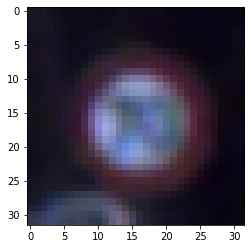

Sign meanings:
 Speed limit to 70


In [41]:
n=128
X_rand_blur, Y_rand_blur = load_random_n_blurred_images_dataset(n)
show_image(random.randint(0,n),X_rand_blur, Y_rand_blur)


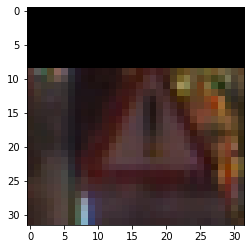

Sign meanings:
 Danger point


In [42]:
X_rand_rect, Y_rand_rect = load_random_n_covered_with_rect_images(n)
show_image(random.randint(0,n),X_rand_rect, Y_rand_rect)

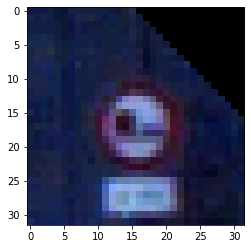

Sign meanings:
 No overtaking for trucks


In [43]:
X_rand_triangle, Y_rand_triangle = load_random_n_covered_with_triangle_images(n)
show_image(random.randint(0,n),X_rand_triangle, Y_rand_triangle)

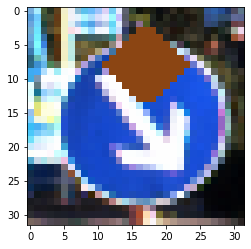

Sign meanings:
 Keep right of traffic barrier/divider


In [44]:
#soiled images
X_soiled, Y_soiled = load_random_n_soiled(n)
#print(X_soiled.shape)
show_image(random.randint(0,n),X_soiled, Y_soiled)

(39209, 32, 32, 3)
(39209, 43)


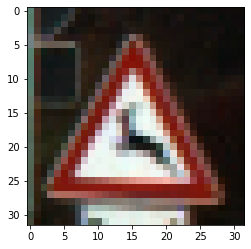

Sign meanings:
 Wild animals possible


In [45]:
X_train, Y_train, X_test, Y_test = load_dataset()
print(X_train.shape)
print(Y_train.shape)
show_image(random.randint(0,12629),X_test, Y_test)

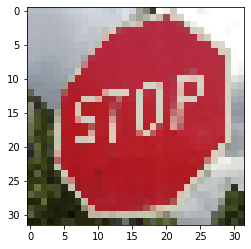

In [46]:
X_polish, Y_polish = load_polish_dataset()
plt.imshow(cv2.cvtColor(X_polish[5],cv2.COLOR_BGR2RGB).astype('float32'))
plt.show()

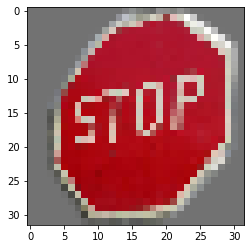

In [47]:
X_polish_solid, Y_polish_solid = load_polish_solid_dataset()
plt.imshow(cv2.cvtColor(X_polish_solid[5],cv2.COLOR_BGR2RGB).astype('float32'))
plt.show()

## Deep learning functions and its tests

In [48]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype='float')
    Y = tf.placeholder(shape=[None, n_y], dtype='float')
    return X, Y

In [49]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [5, 5, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [4, 4, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [3, 3, 16, 32], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W4 = tf.get_variable("W4", [2, 2, 32, 64], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3, 
                  "W4": W4}
    
    return parameters

In [50]:
def forward_propagation(X, parameters):
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    
    # CONV2D: 
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL:
    P1 = tf.nn.max_pool(A1, ksize = [1,5,5,1], strides = [1,5,5,1], padding = 'SAME')
    
    # CONV2D: 
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: 
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    # CONV2D: 
    Z3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A3 = tf.nn.relu(Z3)
    # MAXPOOL:
    P3 = tf.nn.max_pool(A3, ksize = [1,3,3,1], strides = [1,3,3,1], padding = 'SAME')
    
    # CONV2D: 
    Z4 = tf.nn.conv2d(P3, W4, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A4 = tf.nn.relu(Z4)
    # MAXPOOL:
    P4 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # FLATTEN
    F = tf.contrib.layers.flatten(P4)
    # FULLY-CONNECTED without non-linear activation function
    Z5 = tf.contrib.layers.fully_connected(F, 43, activation_fn=None)

    return Z5

In [51]:

def compute_cost(Z5, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z5, labels = Y))

    return cost

In [52]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size : (k+1)*mini_batch_size, :,  :, :]
        mini_batch_Y = shuffled_Y[k*mini_batch_size : (k+1)*mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [53]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 26, minibatch_size = 256, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                         # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run(fetches=[optimizer, cost],
                                         feed_dict={X: minibatch_X,
                                                    Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        print("Train Accuracy:", train_accuracy)
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Test Accuracy:", test_accuracy)

In [54]:
model(X_train, Y_train, X_polish, Y_polish )

Cost after epoch 0: 2.984244


KeyboardInterrupt: 